In [4]:
%load_ext rpy2.ipython

###Some main points

-Use the Autism data set in the TADA package (want to see whether we need the method of moment).

-Change pi ($\pi$) to test the loglikelihood

-Change pi ($\pi$), gamma.mean.dn ($\bar{\gamma_{dn}}$), beta.dn ($\beta_{dn}$) to test the loglikelihood


####Note: 

- likelihood function for m genes

####$\prod_{i=1}^{m}\left[\pi P(x_i|\phi_1) + (1 - \pi)P(x_i|\phi_0)\right]$

- $\gamma_{d} \sim Gamma(\bar{\gamma_d} \beta_d, \beta_d)$

$\gamma_i$: relative risk; $q_i$: allel frequency

##########==================

###Under H0: $\gamma = 1$

$q \sim Gamma(\rho_0, \nu_0)$    OR     $q \sim Gamma(\bar{q_0}\nu_0, \nu_0 )$ 

###Under H1:

$q \sim Gamma(\rho_1, \nu_1)$    OR    $q_i \sim Gamma(\bar{q_1}v_1, v_1)$

$\gamma_i \sim Gamma(\bar{\gamma}\beta, \beta)$

###Hyperparameters

$\phi_1 = (\bar{\gamma}, \beta, \bar{q_1}, v_1)$

$\phi_0 = (\bar{q_0}, v_0)$



###Load data, code

####Parameters below are from TADA package

In [5]:
%%R
source("scripts/TADA/TADAaddEvidence.R")
source("scripts/TADA/likelihoodFunctionCC.R")

#################################################################
# Application of TADA
#################################################################

# Model parameters: two categories of mutations - LoF and mis3 mutations ("probably damaging" by PolyPhen2)
mu.frac <- c(0.074, 0.32)
gamma.mean.dn <- c(20, 4.7)
beta.dn <- c(1,1)
gamma.mean.CC <- c(2.3, 1.00)
beta.CC <- c(4.0, 1000)
rho1 <- c(0.1, 0.5)
nu1 <- c(200, 100)
rho0 <- c(0.1, 0.5)
nu0 <- c(200, 100)
hyperpar <- as.array(rbind(gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0))
l <- 100
pi0 <- 0.94 # the fraction of non-risk genes

# ASC (Autism Sequencing Consortium) data
# The file name contains the sample size information
# The only relevant counts are dn.LoF and dn.mis3
data <- read.csv("scripts/TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header=TRUE, as.is=TRUE)
ntrio <- 2231  # number of trios
ncase <- 1601  # number of cases
nctrl <- 5397  # number of controls
ntrans <- 1333 # number of subjects with transmission data
N <- list(dn=ntrio, ca=ntrans+ncase, cn=ntrans+nctrl)


counts <- as.array(cbind(data$dn.LoF, data$case.LoF+data$trans.LoF, data$ctrl.LoF+data$ntrans.LoF, data$dn.mis3, data$case.mis3+data$trans.mis3, data$ctrl.mis3+data$ntrans.mis3))

dim(counts)
colnames(counts) <- c("dn", "case.LoF", "ctrl.LoF", 1:3)
head(counts)


     dn case.LoF ctrl.LoF 1  2  3
[1,]  0        0        1 0  7  7
[2,]  0        2        3 0  3 14
[3,]  0        0        0 0  0  0
[4,]  0        2        5 0 10 28
[5,]  0        5       22 0 11 40
[6,]  0        1        2 0  3  6


In [6]:
%%R
head(data)

    Gene  mut.rate dn.LoF case.LoF ctrl.LoF trans.LoF ntrans.LoF dn.mis3
1   A1BG 2.355e-05      0        0        1         0          0       0
2   A1CF 2.174e-05      0        1        2         1          1       0
3  A2LD1 6.090e-06      0        0        0         0          0       0
4    A2M 5.640e-05      0        1        5         1          0       0
5  A2ML1 5.700e-05      0        3       16         2          6       0
6 A4GALT 2.415e-05      0        0        2         1          0       0
  case.mis3 ctrl.mis3 trans.mis3 ntrans.mis3
1         0         4          7           3
2         0         7          3           7
3         0         0          0           0
4         4        22          6           6
5         5        30          6          10
6         1         5          2           1


In [7]:
%%R
hyperpar

               [,1]   [,2]
gamma.mean.dn  20.0    4.7
beta.dn         1.0    1.0
gamma.mean.CC   2.3    1.0
beta.CC         4.0 1000.0
rho1            0.1    0.5
nu1           200.0  100.0
rho0            0.1    0.5
nu0           200.0  100.0


###If we only change pi0

In [29]:
%%R
#Only de novo data
piSeq <- seq(0.01, 0.15, by = 0.015)

muData <- cbind(data$mut.rate*mu.frac[1])

likeLihoodValueDN <- lapply(piSeq, function(pi_0)
    logLik(hyperpar = hyperpar, pi = pi_0, counts = counts, N = N, mu = muData,
            denovo.only = TRUE)$marginal
    )
    

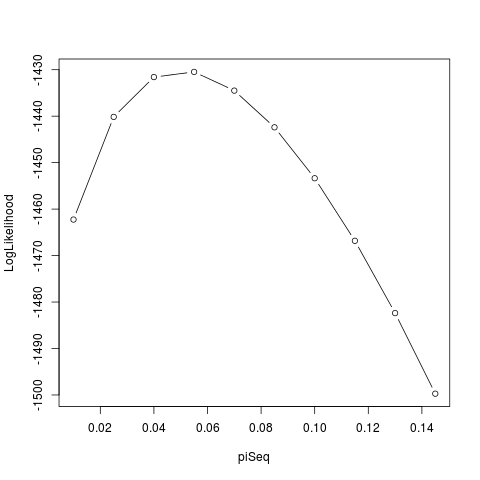

In [30]:
%%R
#Maximum likelihood ~ method of moment !!!

plot(piSeq, -as.numeric(likeLihoodValueDN), type = 'b', ylab = 'LogLikelihood')




###We will change three parameters: beta, gamma, pi



In [31]:
%%R
#Only de novo data
piSeq <- seq(0.01, 0.12, by = 0.01)
gamma.dn.LoF.seq <- seq(10, 30, by = 0.25)
beta.dn.LoF.seq <- seq(0.5, 2.5, by = 0.25)


In [32]:
%%R
nG <- length(gamma.dn.LoF.seq)
nPi <- length(piSeq)
nBeta <- length(beta.dn.LoF.seq)
hyperTemp <- hyperpar
matrixLLK <- matrix(0, ncol = 4, nrow = nBeta*nG*nPi)
indexI <- 1

dim(matrixLLK)

[1] 8748    4


In [33]:
%%R

muData <- cbind(data$mut.rate*mu.frac[1])


for (ii in 1:nG){
    hyperTemp[1, 1] <- gamma.dn.LoF.seq[ii]
    
    for (jj in 1:nPi){
        for (kk in 1:nBeta){
            hyperTemp[2, 1] <- beta.dn.LoF.seq[kk]
        matrixLLK[indexI, 4] <- 
            logLik(hyperpar = hyperTemp, pi = piSeq[jj], counts = counts, N = N, mu = muData,
            denovo.only = TRUE)$marginal
            
        matrixLLK[indexI, 2] <- piSeq[jj]

         matrixLLK[indexI, 1] <- gamma.dn.LoF.seq[ii]
   
            matrixLLK[indexI, 3] <- beta.dn.LoF.seq[kk]
        indexI <- indexI + 1
                }}
}

In [92]:
%%R
matrixLLK[, 4] <- -matrixLLK[, 4]
head(matrixLLK)

     [,1] [,2] [,3]      [,4]
[1,]   10 0.01 0.50 -1487.137
[2,]   10 0.01 0.75 -1488.947
[3,]   10 0.01 1.00 -1489.948
[4,]   10 0.01 1.25 -1490.585
[5,]   10 0.01 1.50 -1491.027
[6,]   10 0.01 1.75 -1491.351


In [93]:
%%R
head(matrixLLK[order(-matrixLLK[, 4]), ], 30)

       [,1] [,2] [,3]      [,4]
 [1,] 30.00 0.03 0.50 -1427.525
 [2,] 29.75 0.03 0.50 -1427.576
 [3,] 29.50 0.03 0.50 -1427.633
 [4,] 29.25 0.03 0.50 -1427.695
 [5,] 29.00 0.03 0.50 -1427.764
 [6,] 30.00 0.03 0.75 -1427.810
 [7,] 26.00 0.04 0.50 -1427.833
 [8,] 25.75 0.04 0.50 -1427.837
 [9,] 26.25 0.04 0.50 -1427.837
[10,] 28.75 0.03 0.50 -1427.839
[11,] 26.50 0.04 0.50 -1427.850
[12,] 25.50 0.04 0.50 -1427.850
[13,] 29.75 0.03 0.75 -1427.866
[14,] 26.75 0.04 0.50 -1427.870
[15,] 25.25 0.04 0.50 -1427.871
[16,] 27.00 0.04 0.50 -1427.898
[17,] 25.00 0.04 0.50 -1427.900
[18,] 28.50 0.03 0.50 -1427.920
[19,] 29.50 0.03 0.75 -1427.929
[20,] 27.25 0.04 0.50 -1427.934
[21,] 24.75 0.04 0.50 -1427.939
[22,] 30.00 0.03 1.00 -1427.965
[23,] 27.50 0.04 0.50 -1427.977
[24,] 24.50 0.04 0.50 -1427.987
[25,] 29.25 0.03 0.75 -1427.997
[26,] 28.25 0.03 0.50 -1428.007
[27,] 29.75 0.03 1.00 -1428.025
[28,] 27.75 0.04 0.50 -1428.028
[29,] 24.25 0.04 0.50 -1428.043
[30,] 30.00 0.03 1.25 -1428.064


In [2]:
###Plot these results

In [1]:
%%R
plot(matrixLLK[, 2], matrixLLK[, 4], xlab = 'pi0', ylab = 'LogLikelihood')
plot(matrixLLK[, 3], matrixLLK[, 4], xlab = 'beta.dn', ylab = 'LogLikelihood')
plot(matrixLLK[, 1], matrixLLK[, 4], xlab = 'gamma.dn', ylab = 'LogLikelihood')

ERROR: Cell magic `%%R` not found.


In [56]:
!gist -p Check_parameters_forLikelihoodFunction.ipynb

https://gist.github.com/865fd03bdf6bbb6ec0c6


In [95]:
!gist -u https://gist.github.com/865fd03bdf6bbb6ec0c6 Check_parameters_forLikelihoodFunction.ipynb

/bin/sh: 1: gist: not found
